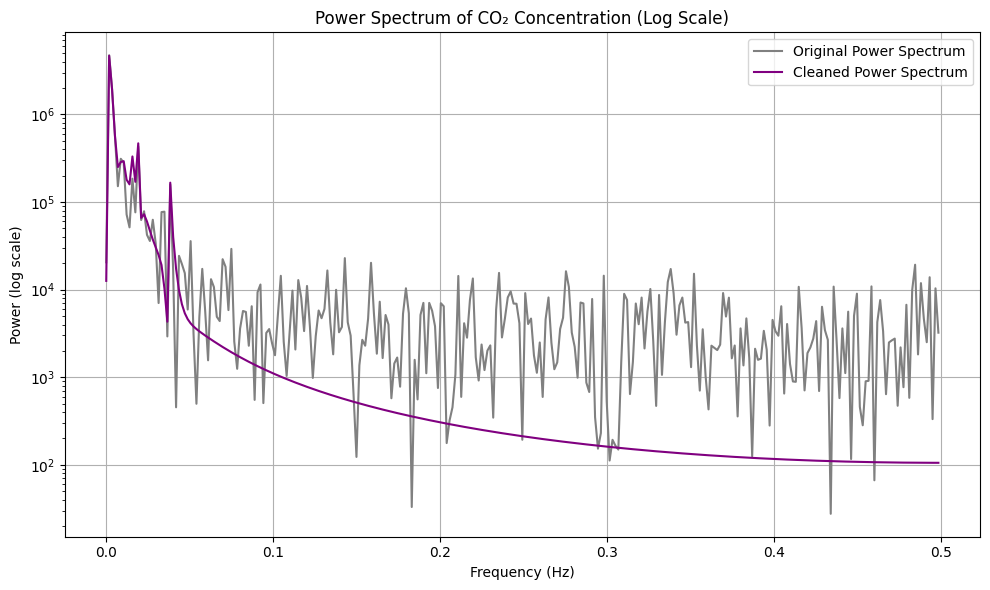

In [2]:
"""
Module for processing and visualizing CO₂ concentration data.
This module loads CO₂ concentration data from a JSON file, processes the time series by removing trends
and resampling it to a regular interval, computes the power spectrum using FFT, cleans the spectrum,
and then visualizes both the original and cleaned power spectra on a single plot.
"""

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import windows

def get_timeseries2(path):
    """
    Load and process CO₂ concentration data from a JSON file using a corrected function.
    """
    try:
        # Load the JSON file into a DataFrame
        data = pd.read_json(path)

        # Convert 'datetime' to datetime format with timezone info
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Group by datetime and average the 'value' column to handle duplicates
        co2_series = data.groupby('datetime')['value'].mean()
        
        return co2_series
    
    except (ValueError, FileNotFoundError) as e:
        print(f"Error reading JSON file: {e}")
        return pd.Series()  # Return an empty series if there's an error

def preprocess_series(co2_series):
    """
    Detrend and resample the CO₂ time series to ensure regular intervals.
    """
    # Remove the mean to detrend the data
    co2_series = co2_series - co2_series.mean()
    
    # Resample to weekly intervals and interpolate missing values
    co2_series = co2_series.resample('W').mean().interpolate()
    
    return co2_series

def clean_power_spectrum(co2_array, window_type='hamming', padding=True, threshold=1e4):
    """
    Clean the power spectrum by windowing, zero-padding, and noise filtering.
    """
    # Apply windowing (Hamming by default)
    window = windows.get_window(window_type, len(co2_array))
    co2_array_windowed = co2_array * window
    
    # Padding (zero-padding)
    if padding:
        padded_length = len(co2_array) * 2  # Double the length for better frequency resolution
        co2_array_padded = np.pad(co2_array_windowed, (0, padded_length - len(co2_array_windowed)), mode='constant')
    else:
        co2_array_padded = co2_array_windowed
    
    # Perform FFT
    fft_values = fft(co2_array_padded)
    power_spectrum = np.abs(fft_values) ** 2  # Power spectrum
    
    # Filter noise in the power spectrum by applying a threshold
    power_spectrum[power_spectrum < threshold] = 0
    
    # Inverse FFT to recover the signal
    filtered_fft_values = ifft(np.sqrt(power_spectrum) * np.exp(1j * np.angle(fft_values)))
    
    # Undo padding (trim back to original length)
    filtered_signal = filtered_fft_values[:len(co2_array)]
    
    # Undo windowing (compensate for the windowing effect)
    filtered_signal /= window
    
    return filtered_signal

def plot_spectra(co2_series, window_type='hamming', padding=True):
    """
    Plot the original and cleaned power spectra of the CO₂ concentration time series on a single graph.
    """
    # Remove NaN values if any
    co2_series = co2_series.dropna()

    # Convert to a NumPy array for FFT
    co2_array = co2_series.values

    # Perform FFT for the original power spectrum
    fft_values = fft(co2_array)
    power_spectrum = np.abs(fft_values) ** 2  # Power spectrum

    # Clean the power spectrum (windowing, padding, noise removal, inverse FFT)
    filtered_signal = clean_power_spectrum(co2_array, window_type, padding)

    # Perform FFT on the filtered signal to get the cleaned power spectrum
    fft_values_filtered = fft(filtered_signal)
    power_spectrum_filtered = np.abs(fft_values_filtered) ** 2  # Cleaned power spectrum

    # Frequency values for the X-axis
    sample_spacing = 1
    freqs = fftfreq(len(power_spectrum), d=sample_spacing)

    # Only plot the positive frequencies (one-sided spectrum)
    positive_freqs = freqs[freqs >= 0]
    positive_power = power_spectrum[freqs >= 0]
    positive_power_filtered = power_spectrum_filtered[freqs >= 0]

    # Create the plot
    plt.figure(figsize=(10, 6))
    # Plot the original power spectrum
    plt.plot(positive_freqs, positive_power, color='grey', label='Original Power Spectrum')
    # Plot the cleaned power spectrum
    plt.plot(positive_freqs, positive_power_filtered, color='purple', label='Cleaned Power Spectrum')
    plt.yscale('log')
    plt.title("Power Spectrum of CO₂ Concentration (Log Scale)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (log scale)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run plots
path = r"/workspaces/CP1-24-HW5/CO2_International_Data/co2_international_data.json"
co2_series = get_timeseries2(path)
co2_series = preprocess_series(co2_series)
plot_spectra(co2_series, window_type='hamming', padding=True)
